In [54]:
import pandas as pd
import numpy as np
from pathlib import Path
import wave
import sys
import os
import soundfile as sf
import librosa
# from pydub import AudioSegment
from scipy.io import wavfile
from scipy.stats import entropy
from dataclasses import (
    dataclass,
    asdict,
    fields,
)
from typing import (
    Optional,
    Callable,
    Set,
    Generator,
    List,
    Tuple,
    Union,
    Dict,
    Iterable,
    Any,
)
from functools import (
    partial,
)
import time
import dill
import logging
import multiprocessing
from tqdm import tqdm
from transformers import (
    AutoTokenizer, 
    AutoModel, 
    Wav2Vec2ForSequenceClassification, 
    Wav2Vec2FeatureExtractor,
    Wav2Vec2Processor,

)
import transformers
import torch
import torchaudio
from pyannote.audio import Model
import pickle
import seaborn as sns
from enum import Enum
from catboost import (
    CatBoostClassifier, 
    CatBoost,
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_curve, 
    auc,
    classification_report,
    ConfusionMatrixDisplay,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import (
    StandardScaler, 
    LabelEncoder,
    label_binarize,
)
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance, partial_dependence
import shap
from sklearn.utils._bunch import Bunch
from sklearn.calibration import CalibratedClassifierCV

import matplotlib.pyplot as plt
from mapie.classification import (
    EnsembleClassifier, # MapieClassifier
    ClassifierMixin,
    BaseClassificationScore,
    _MapieClassifier,
)
sys.path.append(os.getenv('MASTER_DEPLOMA_PROJECT_FILE_PATH'))

from audio import (
    Audio,
    WAVFilePathInitArgs,
)
from high_level_feature_extractor.text.profanity import (
    PROFANITY_WORD_FILTER_LANG_NAME,
)
from configs.base import (
    RB_OPEN_FILE_MODE,
    SECONDS_QUANTITY_IN_MINUTE,
    TAB,
    RUSSIAN_VOWELS,
    WB_OPEN_FILE_MODE,
    DROP_DUPLICATES_KEEP_FIRST,
    JOIN_HOW_INNER,
    AGGREGATED_KEYWORD,
    EPSILON,
)
from configs.report_tables_format import (
    classification_report_formatted,
)
from configs.plots import (
    ALIGN_CENTER_KEYWORD,
    FEATURE_RU,
    NORMED_WEIGHT_RU,
    XTICKS_DEFAULT_ROTATION,
    PARTIAL_DEPENDENCE_KIND_AVERAGE,
    PARTIAL_DEPENDENCE_GRID_VALUES,
)
from processing.text.normalization import (
    normalized_tokens_2_normalized_text,
    text_2_normalized_text,
)
from high_level_feature_extractor.text.profanity import (
    text_2_is_contain_swear_words,
)
from high_level_feature_extractor.text.all import (
    TranscriptionHighLevelFeatures,
)
from high_level_feature_extractor.text.POS import (
    POS_ratio,
)
from high_level_feature_extractor.extractor import (
    HighLevelSpeechFeatures,
    HashHLF,
    hash_HLF_list_2_df,
    PronounceSpeed,
    asdict,
)
from high_level_feature_extractor.extract import (
    raw_crowd_2_HLF,
)
from high_level_feature_extractor.extractor import (
    HLF_ENG_2_RU_RENAMER,
)
from high_level_feature_extractor.store import (
    HLF_withspeaker_emottions_table,
)
from utils.dataclass import (
    flatten_dict,
)
from configs.paths import (
    PROCESSED_DUSHA_CROWD_TRAIN_DIR_PATH,
    PROCESSED_DUSHA_CROWD_TEST_DIR_PATH,
    PROCESSED_DUSHA_CROWD_TRAIN_TEXT_EMBEDDINGS_LAST_VERSION_FILE_PATH,
    PROCESSED_DUSHA_CROWD_TEST_TEXT_EMBEDDINGS_LAST_VERSION_FILE_PATH,
    MY_LAST_CATBOOST_MODEL_PATH,
    MY_LAST_DTREE_MODEL_PATH,
    DUSHA_CROWD_TRAIN_FILE_PATH,
    DUSHA_CROWD_TEST_FILE_PATH,
    DUSHA_CROWD_TRAIN_WAVS_DIR_PATH,
    DUSHA_CROWD_TEST_WAVS_DIR_PATH,
    PROCESSED_DUSHA_CROWD_TRAIN_HLF_LAST_VERSION_FILE_PATH,
    PROCESSED_DUSHA_CROWD_TEST_HLF_LAST_VERSION_FILE_PATH,
    PROCESSED_DUSHA_CROWD_TRAIN_HLF_STABLE_VERSION_FILE_PATH,
    PROCESSED_DUSHA_CROWD_TEST_HLF_STABLE_VERSION_FILE_PATH,
    DO_NOT_EXTRACTED_FEATUERS_HASHES_FILE_PATH,
    PROCESSED_DUSHA_SER_TABLES_TRAIN_FILE_PATH,
    PROCESSED_DUSHA_SER_TABLES_TEST_FILE_PATH,
    SEPFORMER_16KHZ_DIR_PATH,
    TRAIN_INODE_NAME,
    TEST_INODE_NAME,
    DATASET_PARTS_NAMES,
    PART_NAME_2_WAVS_DIR_PATH,
    PART_NAME_2_PROCESSED_DUSHA_CROWD_DIR_PATH,
    DUSHA_WAVS_DIR_NAME,
    W2V_BIO_DIR_PATH,
)
from models.config import (
    TORCH_TENSORS_KEYWOED,
    ATTENTION_MASK_KEYWORD,
    SKLEARN_MULTINOMIAL_KEYWORD,
)
from models.text_embedding.ru_en_RoSBERTa import (
    DEVICE as ROSBERTA_DEVICE,
    NORMALIZE_P as ROSBERTA_NORMALIZE_P,
    NORMALIZE_DIM as ROSBERTA_NORMALIZE_DIM,
    CLAMP_MIN,
)
from models.VQE.sepformer import (
    VQEArgs,
    Sepformer,
)
from models.asr.whisper import (
    PROCESSED_DUSHA_CROWD_TRANSCRIPTIONS_WHISPER_LARGE_V3_FILE_PATH,
)
from models.asr.transcribe import (
    TRANSCRIPTION_COLUMN_NAME,
)
from models.bio.wav2vec2_large_robust.predict import (
    PROCESSED_DUSHA_CROWD_W2V_BIO_FILE_PATH,
    PredictOutput,
)
from models.bio.wav2vec2_large_robust.model import (
    BIO_MODEL_DEVICE,
    BIO_MODEL_AGE_MULTIPLIER,
    Wav2VecBioModel,
    Wav2VecBioModelPredProba,
)
from config import (
    SPEAKER_TEXT_FIELD_NAME,
    PREDICTIONS_COL_NAME,
    RANDOM_SEED,
    AUDIO_PATH_FIELD_NAME,
)
from utils.parallel_processing import (
    divide_into_chunks,
)
from utils.dump_objects import (
    dump_2_file,
    read_dumped,
)
from configs.datasets.dusha import (
    HASH_ID_COLUMN_NAME,
    GoldenEmo,
    SPEAKER_EMOTION_FIELD_NAME,
    ANNOTATOR_EMOION_FIELD_NAME,
    ANNOTATOR_ANSWERS_AGGREGATING_THRESHOLD,
    ANNOTATOR_AGGREGATED_FIELD_NAME,
    SAMPLE_RATE,
)
from processing.text.normalization import (
    text_to_normalized_tokens,
)
from configs.datasets.aggregation import (
    aggregate_by_mode,
)
from models.quality_estimating.feature_importance import (
    normalized_feature_importance,
)
# from metrics.classification.confusion_matrix import(
#     show_all_classification_metrics,
#     plot_roc_auc_curve
# )
from metrics.classification.all import(
    show_all_classification_metrics,
)
from metrics.classification.ROC_AUC import(
    plot_roc_auc_curve,
)
from metrics.insights.feature_importance import (
    normalized_feature_importance_plot,
)
from visualization.insights.SHAP import (
    shap_tree_feature_importance,
    feature_shap_dependence_plot,
    shap_row_waterfall_plot,
)
from visualization.insights.partial_dependence import (
    plot_partial_dependence_catboost,
    cb_model_2_feature_importance_series,
)
from visualization.EDA.correlation import (
    plot_features_corr_matrix,
    plot_feature_class_corr_matrix,
)
from processing.features.find_most_correlated import (
    most_correlated_features_to_drop,
)

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%load_ext autoreload
%autoreload all

/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/IPython/extensions/autoreload.py:215: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if not hasattr(module, "__file__") or module.__file__ is None:


In [3]:
UNCERTAINTY_ESTIMATION_PLOTS_FIGSIZE:Tuple[int, int] = (4,4)

# Extract

## HLF

In [4]:
# EXAMPLE_AUDIO_PATH:Path = Path('/data01/vvkiselev/data/other/dpl/dusha/crowd/crowd_train/wavs/8ef9b8846e044d8aa1f6e390cd1fec85.wav')
EXAMPLE_AUDIO_PATH:Path = Path('/data01/vvkiselev/data/other/dpl/processed/dusha/crowd/train/wavs/8ef9b8846e044d8aa1f6e390cd1fec85.wav')

In [5]:
# audio_example:Audio = Audio.wav_file_path_init(path=EXAMPLE_AUDIO_PATH, transcription='ахах, пиздец')
arguments:WAVFilePathInitArgs = WAVFilePathInitArgs(path=EXAMPLE_AUDIO_PATH, transcription='Mózg ujękować')
audio_example:Audio = Audio.wav_file_path_init(arguments=arguments)
audio_example

Audio(hash='8ef9b8846e044d8aa1f6e390cd1fec85', sample_width=2, sr=16000, n_frames=60160, data=array([ -9, -17, -27, ...,  12,  42,  63], dtype=int16), _transcription='Mózg ujękować', n_channels=1)

In [6]:
# HLF_example:HighLevelSpeechFeatures = HighLevelSpeechFeatures.wav_path_init(path=EXAMPLE_AUDIO_PATH, transcription='бля зачем')
HLF_example:HighLevelSpeechFeatures = HighLevelSpeechFeatures.audio_init(audio=audio_example)
HLF_example

HighLevelSpeechFeatures(loudness=66.49939368651269, HF_power_ratio=0.016770920419493896, pronounce_speed=PronounceSpeed(WPS=3.191489361702128, LPS=3.191489361702128, SPS=0.0), transcription_features=TranscriptionHighLevelFeatures(mean_words_length=6.0, profanity_words_ratio=0.0, meaning=0.0, POS_ratio=POS_ratio(ADVB=0.0, COMP=0.0, CONJ=0.0, GRND=0.0, INFN=0.0, INTJ=0.0, PRCL=0.0, PRED=0.0, PREP=0.0, VERB=0.0, ADJS=0.0, PRTS=0.0, NPRO=0.0, NOUN=0.0, ADJF=0.0, NUMR=0.0, PRTF=0.0, NONE=1.0)))

### Read


#### Audio and text

In [7]:
raw_crowd_train, raw_crowd_test = list(map(lambda path: pd.read_csv(path, sep=TAB), [DUSHA_CROWD_TRAIN_FILE_PATH, DUSHA_CROWD_TEST_FILE_PATH]))
print(raw_crowd_train.shape)
display(raw_crowd_train.head(2))

print(raw_crowd_test.shape)
display(raw_crowd_test.head(2))

(906953, 9)


,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
0,475e76f77ac1ed7cabafca740b15b32a,wavs/475e76f77ac1ed7cabafca740b15b32a.wav,2.453,angry,NaN,858305a5450b7bd1288ba0053b1cd1c1,не надо не надо не надо не надо,angry,fa136da095807ea6cd18dd6e2f58d4d0
1,2f9438ef68395c70a8714dc373a49d11,wavs/2f9438ef68395c70a8714dc373a49d11.wav,4.640,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,фозил кори mp три,neutral,3d436884cbbe25373914f8768de494f7


(79088, 9)


,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
0,9e9961c53ca6eeb440b217e539fbf46c,wavs/9e9961c53ca6eeb440b217e539fbf46c.wav,5.82,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,я слушаю,neutral,4282ddc30d71ef420e202e0c60391e9f
1,0166f65a30354db8282682b1a280e64c,wavs/0166f65a30354db8282682b1a280e64c.wav,3.70,sad,NaN,858305a5450b7bd1288ba0053b1cd1c1,каким стал сбер,neutral,d70dc98ed56e9362eaefefb7b2827c8f


In [91]:
len(raw_crowd_train.source_id.unique()) + len(raw_crowd_test.source_id.unique())

2069

In [8]:
# part_name_2_raw_crowd:Dict[str, pd.DataFrame] = {}
# #TODO delete hardcode
# part_name_2_raw_crowd[TRAIN_INODE_NAME] = raw_crowd_train
# part_name_2_raw_crowd[TEST_INODE_NAME] = raw_crowd_test
# len(part_name_2_raw_crowd)

In [9]:
raw_crowd_train[raw_crowd_train.hash_id == '5d9560dd2cba88b2dc87b6b4d5b6a29d']

,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
412403,5d9560dd2cba88b2dc87b6b4d5b6a29d,wavs/5d9560dd2cba88b2dc87b6b4d5b6a29d.wav,0.347875,other,NaN,09184134bd1ddeb646205ba8e981fba8,фильмы меньшова,sad,24725b876b5e72993ec6c35688f754b8
412437,5d9560dd2cba88b2dc87b6b4d5b6a29d,wavs/5d9560dd2cba88b2dc87b6b4d5b6a29d.wav,0.347875,other,NaN,076ffc89109d8d0cb8727de8f75b5c94,фильмы меньшова,sad,24725b876b5e72993ec6c35688f754b8
412457,5d9560dd2cba88b2dc87b6b4d5b6a29d,wavs/5d9560dd2cba88b2dc87b6b4d5b6a29d.wav,0.347875,other,NaN,62942acb4975e3cac00d06726a0dfd83,фильмы меньшова,sad,24725b876b5e72993ec6c35688f754b8
414061,5d9560dd2cba88b2dc87b6b4d5b6a29d,wavs/5d9560dd2cba88b2dc87b6b4d5b6a29d.wav,0.347875,other,NaN,a30fefe82e1e460f186efe6e9bbf9c58,фильмы меньшова,sad,24725b876b5e72993ec6c35688f754b8


In [10]:
len(raw_crowd_train.hash_id.unique()), len(raw_crowd_test.hash_id.unique())

(184633, 17217)

In [11]:
# raw_crowd:pd.DataFrame = raw_crowd_test
# hash_id_2_annotator_emo:pd.Series = pd.Series(
#     index=raw_crowd.hash_id.to_list(), 
#     data=raw_crowd.annotator_emo.to_list(),
# ).sort_index()
# grouped = hash_id_2_annotator_emo.groupby(hash_id_2_annotator_emo.index).apply(aggregate_by_mode).dropna()
# grouped.name = ANNOTATOR_AGGREGATED_FIELD_NAME
# grouped.head()

In [12]:
# Process
# HLF_with_speaker_emotions_train:pd.DataFrame = HLF_withspeaker_emottions_table(
#     raw_crowd=raw_crowd_train,
#     HLF_file_path=PROCESSED_DUSHA_CROWD_TRAIN_HLF_STABLE_VERSION_FILE_PATH
# )

# Read
HLF_with_speaker_emotions_train:pd.DataFrame = pd.read_csv(PROCESSED_DUSHA_SER_TABLES_TRAIN_FILE_PATH, index_col=0)
print(HLF_with_speaker_emotions_train.shape)

display(HLF_with_speaker_emotions_train.head())

(140293, 27)


,loudness,HF_power_ratio,pronounce_speed_WPS,pronounce_speed_LPS,pronounce_speed_SPS,transcription_features_mean_words_length,transcription_features_profanity_words_ratio,transcription_features_meaning,transcription_features_POS_ratio_ADVB,transcription_features_POS_ratio_COMP,transcription_features_POS_ratio_CONJ,transcription_features_POS_ratio_GRND,transcription_features_POS_ratio_INFN,transcription_features_POS_ratio_INTJ,transcription_features_POS_ratio_PRCL,transcription_features_POS_ratio_PRED,transcription_features_POS_ratio_PREP,transcription_features_POS_ratio_VERB,transcription_features_POS_ratio_ADJS,transcription_features_POS_ratio_PRTS,transcription_features_POS_ratio_NPRO,transcription_features_POS_ratio_NOUN,transcription_features_POS_ratio_ADJF,transcription_features_POS_ratio_NUMR,transcription_features_POS_ratio_PRTF,transcription_features_POS_ratio_NONE,annotator_emo_aggregated
475e76f77ac1ed7cabafca740b15b32a,72.867474,0.034653,9.783938,9.783938,4.891969,3.000000,0.0,0.000044,0.000000,0.0,0.000000,0.0,0.0,0.0,0.5,0.5,0.00,0.000000,0.00,0.0,0.0,0.000000,0.0,0.00,0.0,0.00,angry
2f9438ef68395c70a8714dc373a49d11,59.619346,0.002489,3.017241,3.017241,1.077586,3.500000,0.0,0.000062,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.500000,0.0,0.25,0.0,0.25,neutral
fb0ae78586a235018103acec22a80a8f,65.745419,0.009645,5.640303,5.640303,2.051019,5.500000,0.0,0.000059,0.250000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.25,0.250000,0.25,0.0,0.0,0.000000,0.0,0.00,0.0,0.00,neutral
196dcf9e1aaac46c2aee45e7f6adfb92,43.632196,0.002487,7.322176,7.322176,3.556485,7.000000,0.0,0.000069,0.000000,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.00,0.200000,0.00,0.0,0.0,0.400000,0.2,0.00,0.0,0.00,neutral
41d7f48ca93b01e4a01a4f34b40a69ff,53.216042,0.037675,8.438819,8.438819,4.008439,5.714286,0.0,0.000079,0.142857,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.00,0.142857,0.00,0.0,0.0,0.571429,0.0,0.00,0.0,0.00,neutral


In [13]:
HLF_with_speaker_emotions_train.isna().sum()

loudness                                        0
HF_power_ratio                                  0
pronounce_speed_WPS                             0
pronounce_speed_LPS                             0
pronounce_speed_SPS                             0
transcription_features_mean_words_length        0
transcription_features_profanity_words_ratio    0
transcription_features_meaning                  0
transcription_features_POS_ratio_ADVB           0
transcription_features_POS_ratio_COMP           0
transcription_features_POS_ratio_CONJ           0
transcription_features_POS_ratio_GRND           0
transcription_features_POS_ratio_INFN           0
transcription_features_POS_ratio_INTJ           0
transcription_features_POS_ratio_PRCL           0
transcription_features_POS_ratio_PRED           0
transcription_features_POS_ratio_PREP           0
transcription_features_POS_ratio_VERB           0
transcription_features_POS_ratio_ADJS           0
transcription_features_POS_ratio_PRTS           0


In [14]:
HLF_with_speaker_emotions_train = HLF_with_speaker_emotions_train.dropna()

In [15]:
# HLF_with_speaker_emotions_train.to_csv(PROCESSED_DUSHA_SER_TABLES_TRAIN_FILE_PATH)

In [16]:
# process
# HLF_with_speaker_emotions_test:pd.DataFrame = HLF_withspeaker_emottions_table(
#     raw_crowd=raw_crowd_test,
#     HLF_file_path=PROCESSED_DUSHA_CROWD_TEST_HLF_LAST_VERSION_FILE_PATH
# )

# read
HLF_with_speaker_emotions_test:pd.DataFrame = pd.read_csv(PROCESSED_DUSHA_SER_TABLES_TEST_FILE_PATH, index_col=0)
print(HLF_with_speaker_emotions_test.shape)

HLF_with_speaker_emotions_test.head()

(13208, 27)


,loudness,HF_power_ratio,pronounce_speed_WPS,pronounce_speed_LPS,pronounce_speed_SPS,transcription_features_mean_words_length,transcription_features_profanity_words_ratio,transcription_features_meaning,transcription_features_POS_ratio_ADVB,transcription_features_POS_ratio_COMP,transcription_features_POS_ratio_CONJ,transcription_features_POS_ratio_GRND,transcription_features_POS_ratio_INFN,transcription_features_POS_ratio_INTJ,transcription_features_POS_ratio_PRCL,transcription_features_POS_ratio_PRED,transcription_features_POS_ratio_PREP,transcription_features_POS_ratio_VERB,transcription_features_POS_ratio_ADJS,transcription_features_POS_ratio_PRTS,transcription_features_POS_ratio_NPRO,transcription_features_POS_ratio_NOUN,transcription_features_POS_ratio_ADJF,transcription_features_POS_ratio_NUMR,transcription_features_POS_ratio_PRTF,transcription_features_POS_ratio_NONE,annotator_emo_aggregated
9e9961c53ca6eeb440b217e539fbf46c,42.082995,0.016200,1.202749,1.202749,0.687285,3.500000,0.0,0.000043,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,neutral
0166f65a30354db8282682b1a280e64c,33.148046,0.002783,3.513514,3.513514,1.081081,4.333333,0.0,0.000054,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.333333,0.333333,0.0,0.0,0.0,sad
d49a6b560155831725a7bdc7d0a96099,51.286776,0.009615,4.794521,4.794521,1.598174,5.250000,0.0,0.000062,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.500000,0.000000,0.0,0.0,0.0,neutral
c6852b0925797612d7b6724da8cbe7b4,63.554106,0.006752,3.379953,3.379953,0.699301,5.800000,0.0,0.000059,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.200000,0.0,0.0,0.0,0.200000,0.000000,0.0,0.0,0.4,neutral
33152583dcbf1fe40d142954a2a7ca23,65.995071,0.005847,5.657895,5.657895,2.500000,4.300000,0.0,0.000092,0.00,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.200000,0.0,0.0,0.0,0.200000,0.100000,0.0,0.0,0.0,neutral


In [17]:
HLF_with_speaker_emotions_test.isna().sum()

loudness                                        0
HF_power_ratio                                  0
pronounce_speed_WPS                             0
pronounce_speed_LPS                             0
pronounce_speed_SPS                             0
transcription_features_mean_words_length        0
transcription_features_profanity_words_ratio    0
transcription_features_meaning                  0
transcription_features_POS_ratio_ADVB           0
transcription_features_POS_ratio_COMP           0
transcription_features_POS_ratio_CONJ           0
transcription_features_POS_ratio_GRND           0
transcription_features_POS_ratio_INFN           0
transcription_features_POS_ratio_INTJ           0
transcription_features_POS_ratio_PRCL           0
transcription_features_POS_ratio_PRED           0
transcription_features_POS_ratio_PREP           0
transcription_features_POS_ratio_VERB           0
transcription_features_POS_ratio_ADJS           0
transcription_features_POS_ratio_PRTS           0


In [18]:
HLF_with_speaker_emotions_test = HLF_with_speaker_emotions_test.dropna()

#### Bio

In [55]:
bio_table:pd.DataFrame = pd.read_csv(PROCESSED_DUSHA_CROWD_W2V_BIO_FILE_PATH, index_col=HASH_ID_COLUMN_NAME)
bio_series:pd.DataFrame = bio_table[bio_table.columns[0]]
bio_table_wide:pd.DataFrame = pd.DataFrame(data=bio_series.apply(eval).tolist(), index=bio_series.index).drop(columns=['age_multiplier', 'female']) # 'child'  TODO to config
bio_table_wide.age *= BIO_MODEL_AGE_MULTIPLIER
# TODO: mb 'child' in usefull
bio_table_wide.head()

,age,male,child
hash_id,,,
8ef9b8846e044d8aa1f6e390cd1fec85,43.292330,0.025408,0.000219
34fb238d5c91bc5ee1227a7d6e36d64b,50.293064,0.002066,0.000104
74294b6d8a3d7af7551e2601dc667f04,16.378530,0.999060,0.000476
674ff516eb0bc2287f7a676b9016c6c5,25.869867,0.994444,0.000730
c6ce63c2b31052a22f9dbea775bb54d2,31.978380,0.001257,0.000177


In [56]:
# sns.lineplot(x=bio_table_wide.age.values, y=bio_table_wide.child.values)
# plt.show()

In [57]:
HLF_with_speaker_emotions_train.shape

(140293, 27)

In [58]:
HLF_with_bio_speaker_emotions_train:pd.DataFrame= HLF_with_speaker_emotions_train.join(other=bio_table_wide, how=JOIN_HOW_INNER)
assert HLF_with_bio_speaker_emotions_train.shape[0] == HLF_with_speaker_emotions_train.shape[0]

HLF_with_bio_speaker_emotions_test:pd.DataFrame= HLF_with_speaker_emotions_test.join(other=bio_table_wide, how=JOIN_HOW_INNER)
assert HLF_with_bio_speaker_emotions_test.shape[0] == HLF_with_speaker_emotions_test.shape[0]


In [59]:
HLF_with_bio_speaker_emotions_train.head()

,loudness,HF_power_ratio,pronounce_speed_WPS,pronounce_speed_LPS,pronounce_speed_SPS,transcription_features_mean_words_length,transcription_features_profanity_words_ratio,transcription_features_meaning,transcription_features_POS_ratio_ADVB,transcription_features_POS_ratio_COMP,transcription_features_POS_ratio_CONJ,transcription_features_POS_ratio_GRND,transcription_features_POS_ratio_INFN,transcription_features_POS_ratio_INTJ,transcription_features_POS_ratio_PRCL,transcription_features_POS_ratio_PRED,transcription_features_POS_ratio_PREP,transcription_features_POS_ratio_VERB,transcription_features_POS_ratio_ADJS,transcription_features_POS_ratio_PRTS,transcription_features_POS_ratio_NPRO,transcription_features_POS_ratio_NOUN,transcription_features_POS_ratio_ADJF,transcription_features_POS_ratio_NUMR,transcription_features_POS_ratio_PRTF,transcription_features_POS_ratio_NONE,annotator_emo_aggregated,age,male,child
475e76f77ac1ed7cabafca740b15b32a,72.867474,0.034653,9.783938,9.783938,4.891969,3.000000,0.0,0.000044,0.000000,0.0,0.000000,0.0,0.0,0.0,0.5,0.5,0.00,0.000000,0.00,0.0,0.0,0.000000,0.0,0.00,0.0,0.00,angry,49.821550,0.010448,0.000481
2f9438ef68395c70a8714dc373a49d11,59.619346,0.002489,3.017241,3.017241,1.077586,3.500000,0.0,0.000062,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.500000,0.0,0.25,0.0,0.25,neutral,32.820440,0.002805,0.000589
fb0ae78586a235018103acec22a80a8f,65.745419,0.009645,5.640303,5.640303,2.051019,5.500000,0.0,0.000059,0.250000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.25,0.250000,0.25,0.0,0.0,0.000000,0.0,0.00,0.0,0.00,neutral,31.080875,0.002503,0.000287
196dcf9e1aaac46c2aee45e7f6adfb92,43.632196,0.002487,7.322176,7.322176,3.556485,7.000000,0.0,0.000069,0.000000,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.00,0.200000,0.00,0.0,0.0,0.400000,0.2,0.00,0.0,0.00,neutral,24.777250,0.002169,0.000112
41d7f48ca93b01e4a01a4f34b40a69ff,53.216042,0.037675,8.438819,8.438819,4.008439,5.714286,0.0,0.000079,0.142857,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.00,0.142857,0.00,0.0,0.0,0.571429,0.0,0.00,0.0,0.00,neutral,23.924506,0.002838,0.000303


#### Train/test split

In [60]:
HLF_with_bio_speaker_emotions_train, HLF_with_bio_speaker_emotions_test = [df.drop(columns=df.columns[df.nunique() == 1], inplace=False) for df in [HLF_with_bio_speaker_emotions_train, HLF_with_bio_speaker_emotions_test]]

In [61]:
# HLF_with_speaker_emotions_test.to_csv(PROCESSED_DUSHA_SER_TABLES_TEST_FILE_PATH)

In [62]:
X_train:pd.DataFrame = HLF_with_bio_speaker_emotions_train.drop(columns=[ANNOTATOR_AGGREGATED_FIELD_NAME])  
y_train:pd.DataFrame = HLF_with_bio_speaker_emotions_train[ANNOTATOR_AGGREGATED_FIELD_NAME]                

X_test:pd.DataFrame = HLF_with_bio_speaker_emotions_test.drop(columns=[ANNOTATOR_AGGREGATED_FIELD_NAME])   
y_test:pd.DataFrame = HLF_with_bio_speaker_emotions_test[ANNOTATOR_AGGREGATED_FIELD_NAME]                  

X:pd.DataFrame = pd.concat([X_train, X_test], axis=0)
y:pd.Series = pd.concat([y_train, y_test], axis=0)

### Analysis

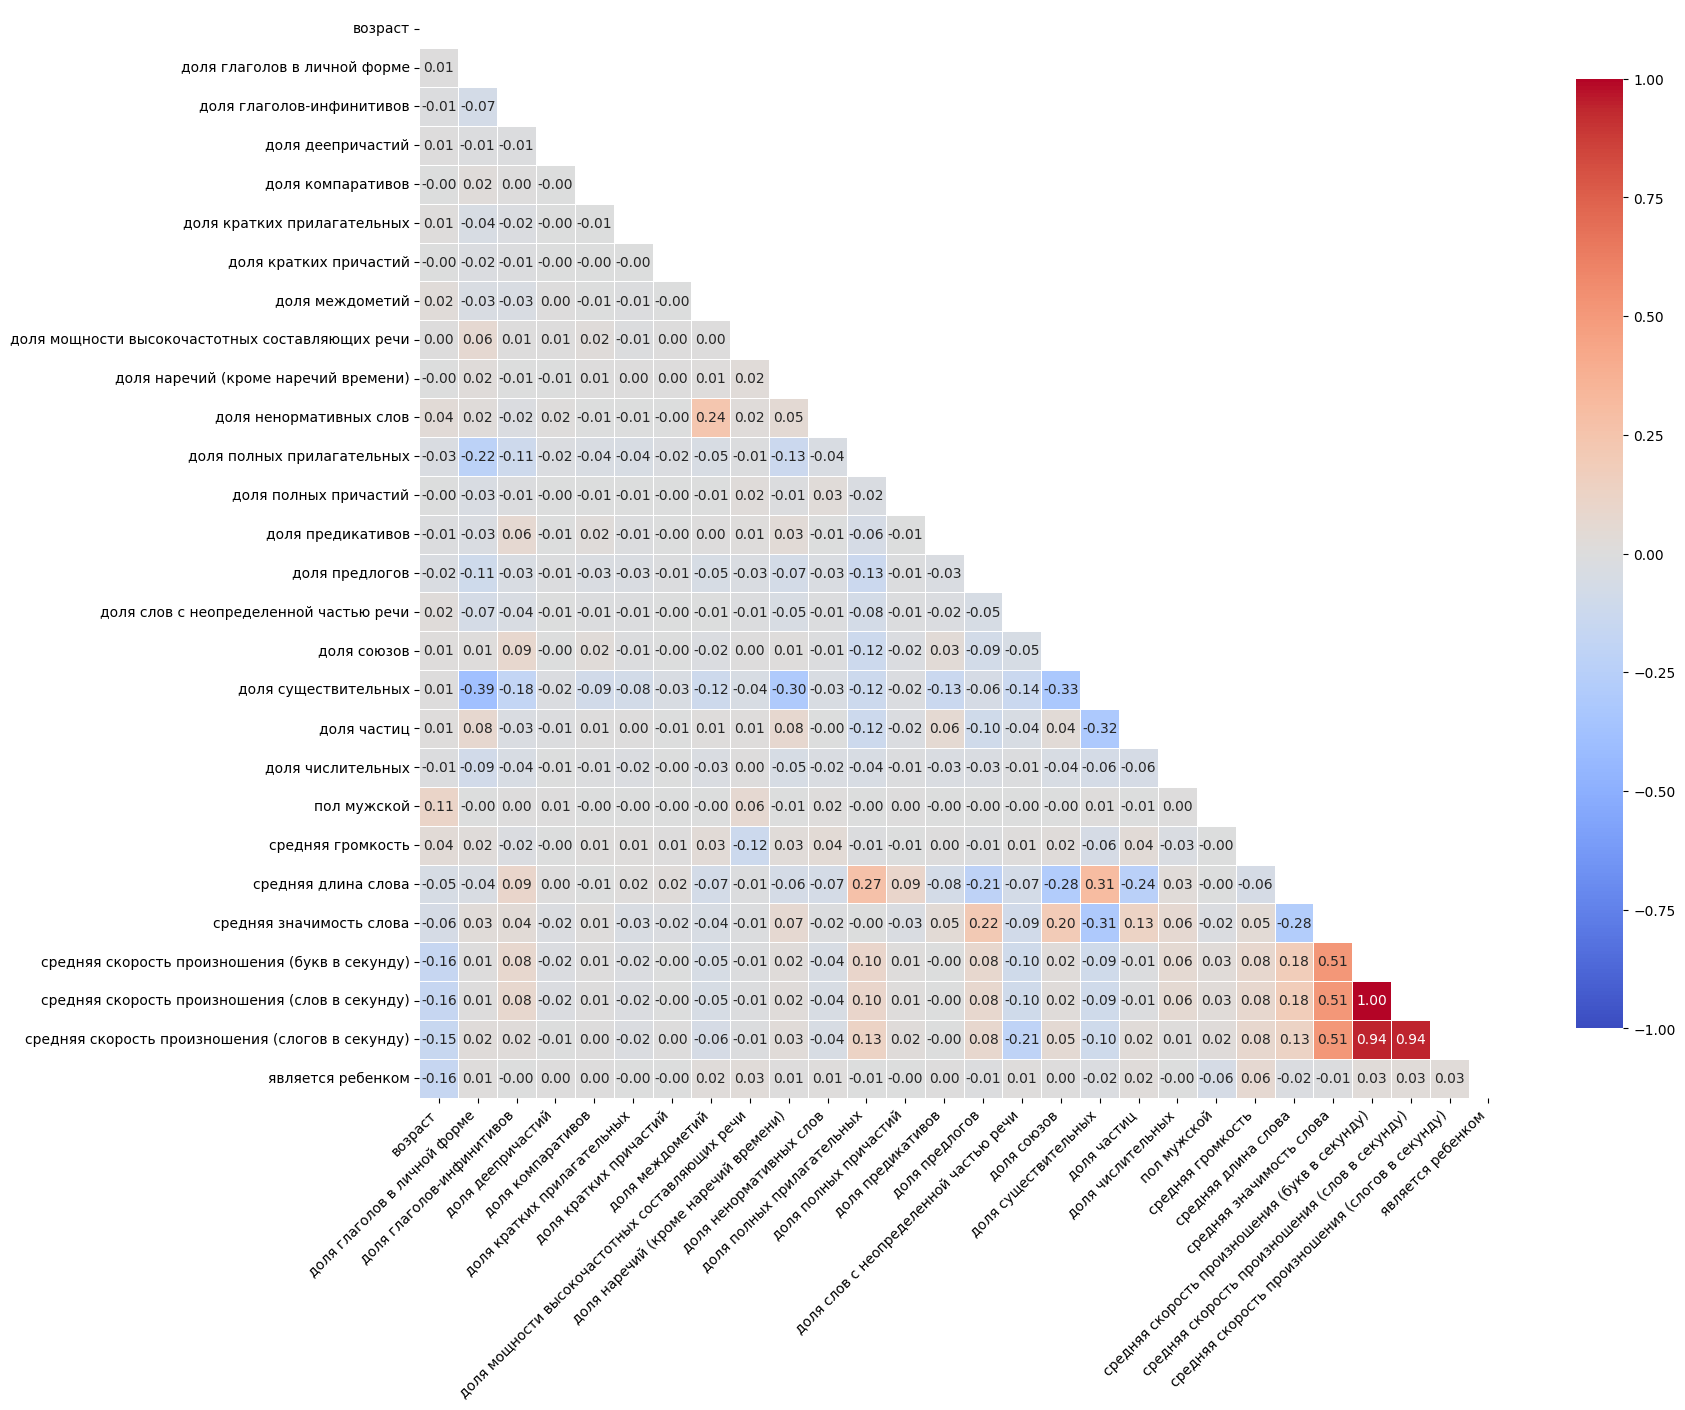

In [63]:
plot_features_corr_matrix(
    X=X.rename(columns=HLF_ENG_2_RU_RENAMER).sort_index(axis=1),
    # is_greys=True,
)

In [64]:
display((X['pronounce_speed_LPS'] / X['pronounce_speed_WPS']).head())
X['transcription_features_mean_words_length'].head()

475e76f77ac1ed7cabafca740b15b32a    1.0
2f9438ef68395c70a8714dc373a49d11    1.0
fb0ae78586a235018103acec22a80a8f    1.0
196dcf9e1aaac46c2aee45e7f6adfb92    1.0
41d7f48ca93b01e4a01a4f34b40a69ff    1.0
dtype: float64

475e76f77ac1ed7cabafca740b15b32a    3.000000
2f9438ef68395c70a8714dc373a49d11    3.500000
fb0ae78586a235018103acec22a80a8f    5.500000
196dcf9e1aaac46c2aee45e7f6adfb92    7.000000
41d7f48ca93b01e4a01a4f34b40a69ff    5.714286
Name: transcription_features_mean_words_length, dtype: float64

In [65]:
correlated_features_to_drop:List[str] = most_correlated_features_to_drop(
    X=X,
)
print(correlated_features_to_drop)
X_train.drop(correlated_features_to_drop, axis=1, inplace=True)
X_test.drop(correlated_features_to_drop, axis=1, inplace=True)

['pronounce_speed_WPS', 'pronounce_speed_LPS']


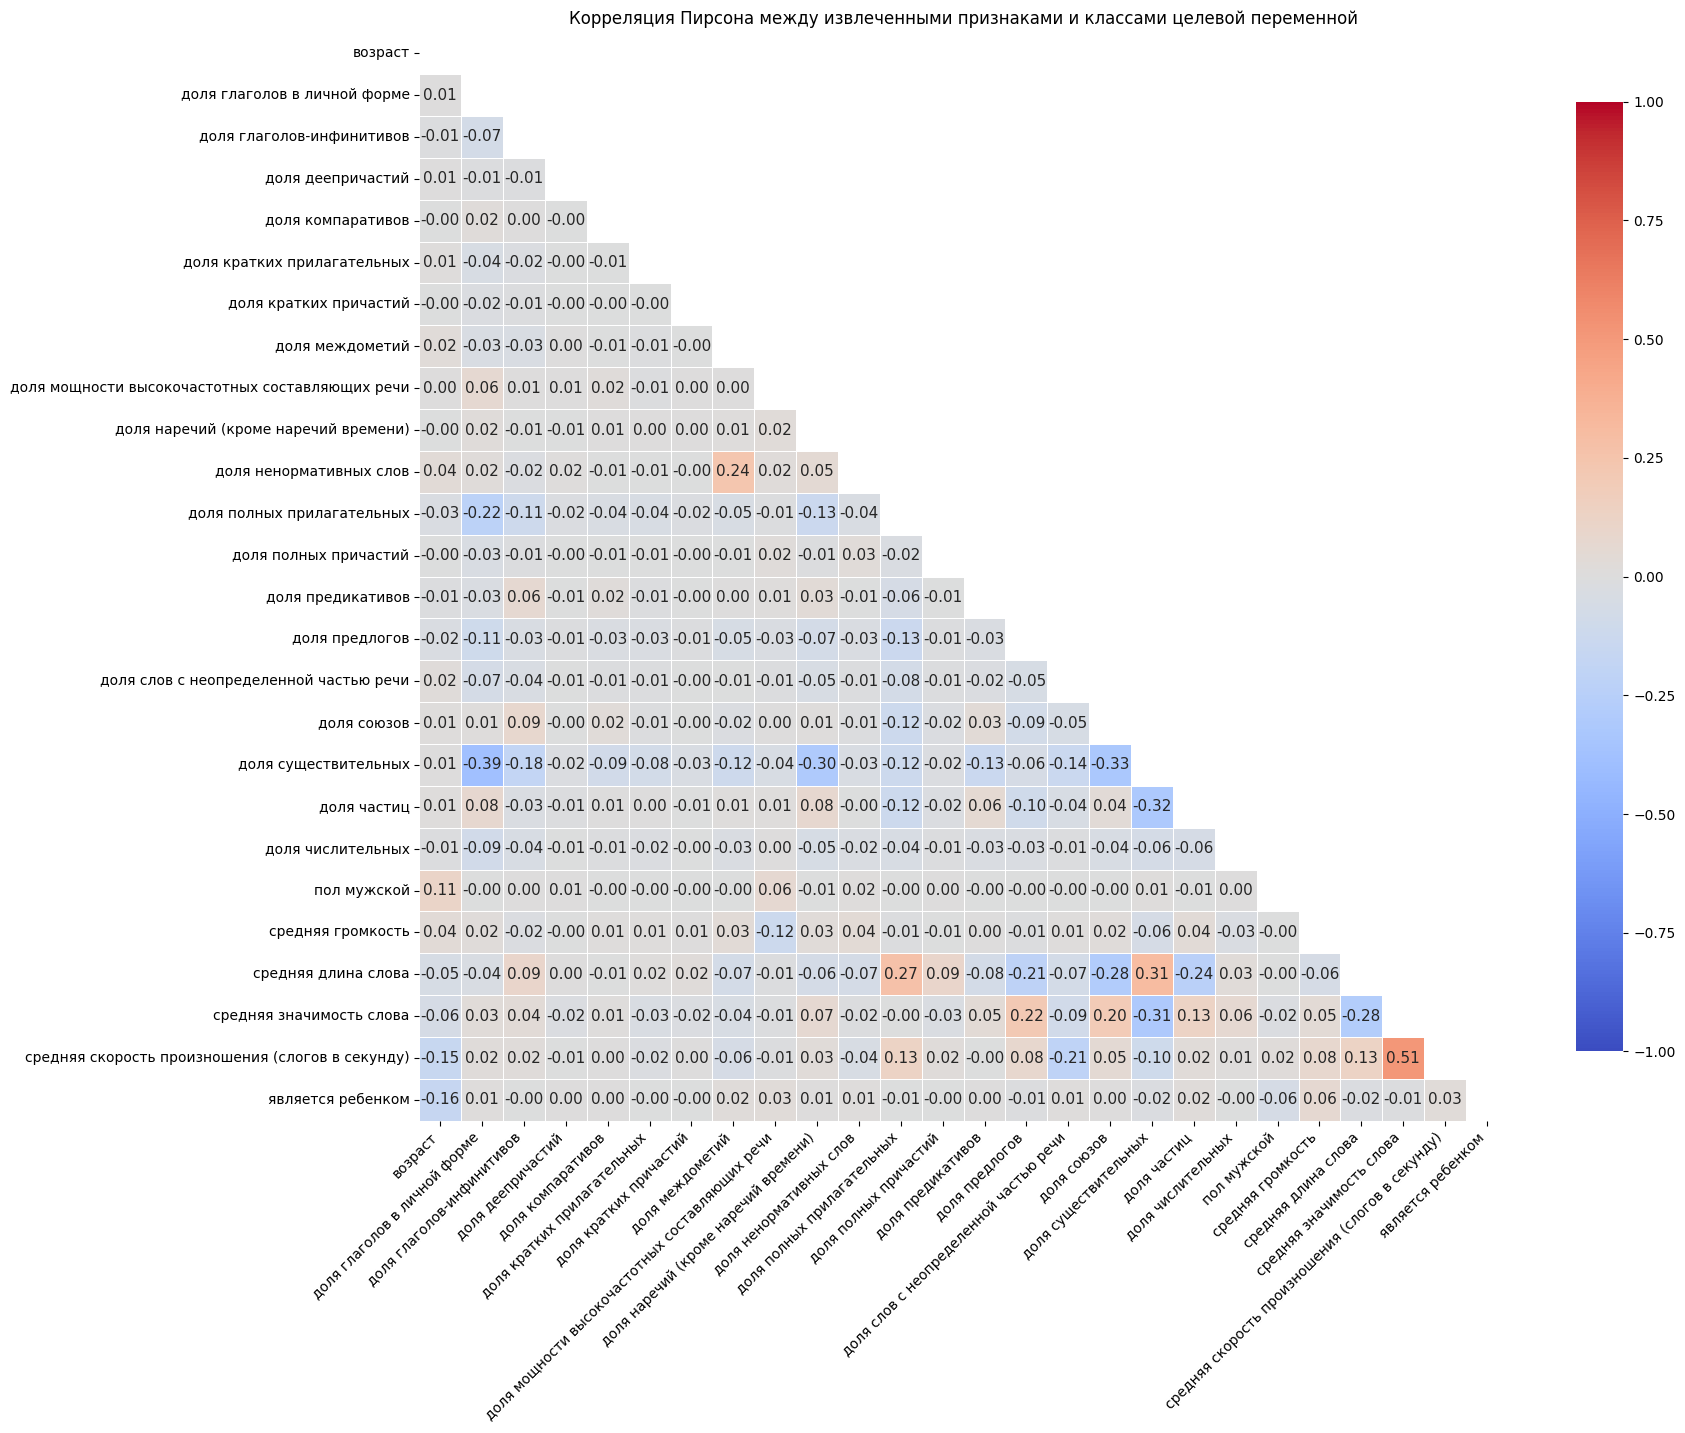

In [89]:
plot_features_corr_matrix(
    X=X.rename(columns=HLF_ENG_2_RU_RENAMER).sort_index(axis=1),
    # is_greys=True,
    title='Корреляция Пирсона между извлеченными признаками и классами целевой переменной',
)

In [67]:
X:pd.DataFrame = pd.concat([X_train, X_test])
y:pd.DataFrame = pd.concat([y_train, y_test])

X_y:pd.DataFrame = pd.concat(
    [
        X, 
        y,
    ],
    axis=1
)
X_y.shape

(153501, 27)

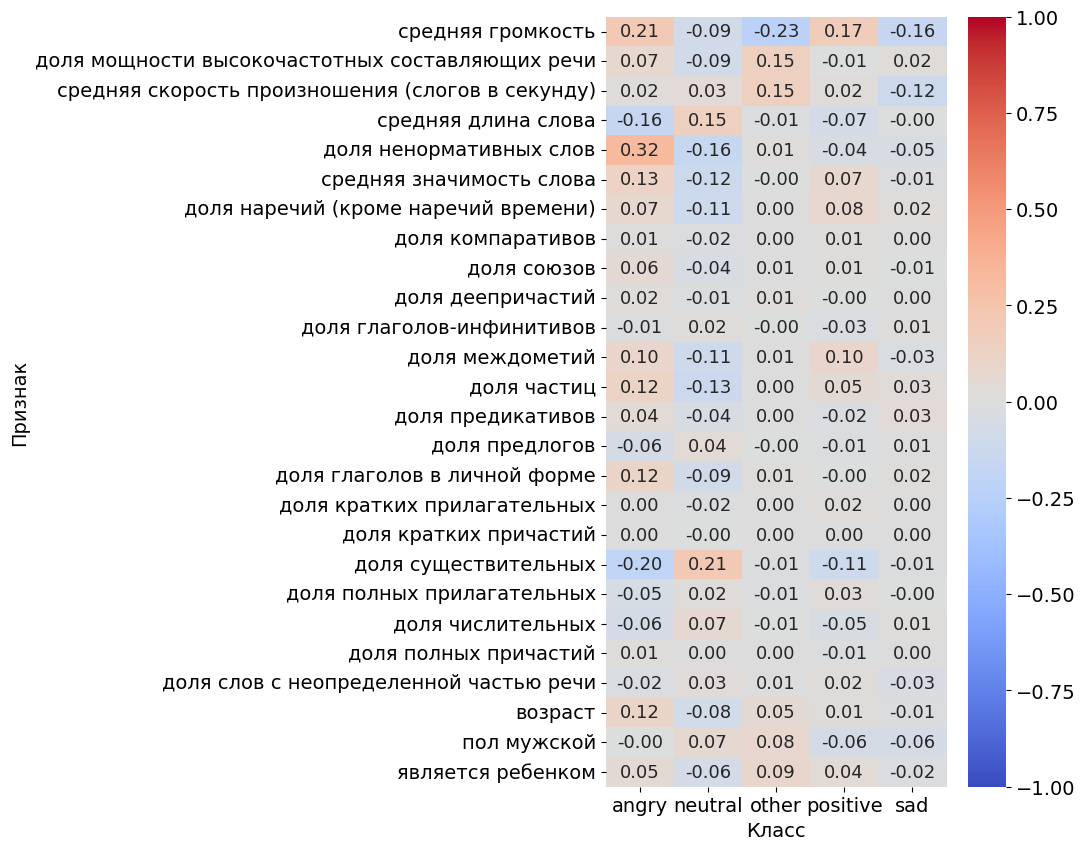

In [68]:
plot_feature_class_corr_matrix(
    X_y=X_y, 
    target_col_name=ANNOTATOR_AGGREGATED_FIELD_NAME, 
    features_renamer=HLF_ENG_2_RU_RENAMER,
    figsize=(5.5, 10),
    # is_greys=True,
)

# Train models

## CatBoost

In [69]:
y_train.head()

475e76f77ac1ed7cabafca740b15b32a      angry
2f9438ef68395c70a8714dc373a49d11    neutral
fb0ae78586a235018103acec22a80a8f    neutral
196dcf9e1aaac46c2aee45e7f6adfb92    neutral
41d7f48ca93b01e4a01a4f34b40a69ff    neutral
Name: annotator_emo_aggregated, dtype: object

In [70]:
wheight_func:Callable = lambda x: 1 if x == GoldenEmo.neutral.name else 1.5

In [71]:
cb:CatBoostClassifier = CatBoostClassifier(
    # iterations=100,       # Number of boosting iterations
    # learning_rate=0.1,    # Learning rate
    # depth=6,              # Depth of the trees
    verbose=0,           # Print progress every 100 iterations
    random_state=RANDOM_SEED,
)

cb.fit(
    X_train, 
    y_train,
    sample_weight=y_train.map(wheight_func),
)

cb_y_pred:pd.Series = pd.Series(cb.predict(X_test).squeeze(1), index=X_test.index, name=PREDICTIONS_COL_NAME)
cb_y_pred_proba:pd.DataFrame = pd.DataFrame(cb.predict_proba(X_test), index=X_test.index, columns=cb.classes_)

margin

In [72]:
# dump_2_file(
#     object=cb, 
#     path=MY_LAST_CATBOOST_MODEL_PATH,
# )
# cb:CatBoostClassifier = read_dumped(
#     path=MY_LAST_CATBOOST_MODEL_PATH
# )

In [73]:
weights:pd.Series = y_test.map(y_test.value_counts())

# Compute weighted accuracy
weighted_acc = accuracy_score(
    y_test, 
    cb_y_pred, 
    sample_weight=weights,
)
print("Weighted Accuracy (by class frequency):", weighted_acc)

Weighted Accuracy (by class frequency): 0.8669084681785431


              precision    recall  f1-score   support

       angry       0.60      0.61      0.61      1436
     neutral       0.74      0.92      0.82      8578
       other       0.95      0.36      0.53       154
    positive       0.50      0.27      0.35      1150
         sad       0.47      0.11      0.17      1890

    accuracy                           0.71     13208
   macro avg       0.65      0.45      0.50     13208
weighted avg       0.67      0.71      0.66     13208



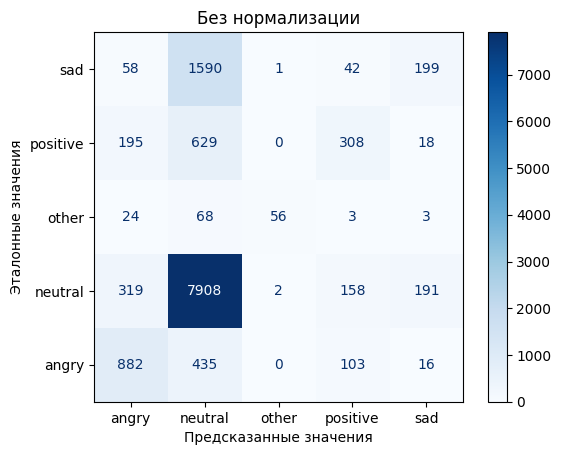

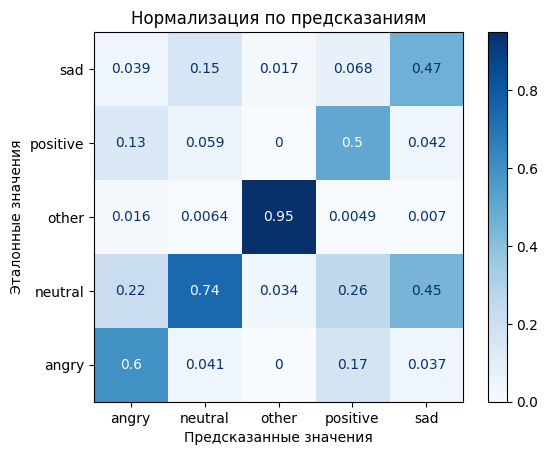

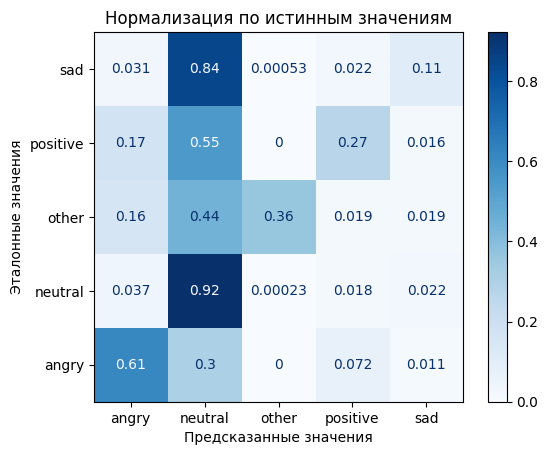

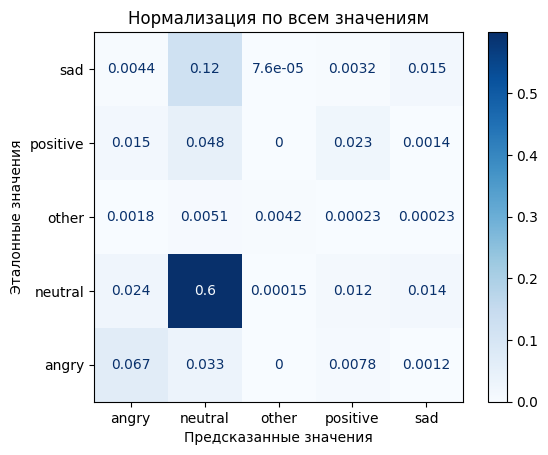

Мультикслассовая ROC-AUC


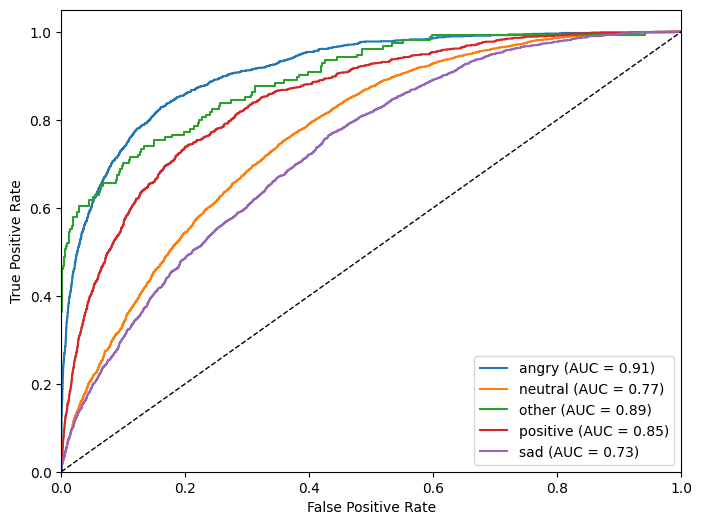

In [74]:
show_all_classification_metrics(y_true=y_test, y_pred_proba=cb_y_pred_proba, plot_roc_auc=True)

In [75]:
n_estimators:int = cb.tree_count_

# Get the depth
depth = cb.get_param('depth')

# Get the number of parameters
n_params = cb.get_params()

print(f"Number of estimators: {n_estimators}")
print(f"Depth: {depth}")
print(f"Number of parameters: {len(n_params)}")


Number of estimators: 1000
Depth: None
Number of parameters: 2


In [76]:
classification_report_formatted(y_true=y_test, y_pred=cb_y_pred, drop_accuracy=False)

accuracy = 0.7081314354936402


/home/vvkiselev/projects/dpl/MyProject/configs/report_tables_format.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'accuracy = {classification_report_table[accuracy_metric_name][0]}')


,angry,neutral,other,positive,sad,accuracy,macro avg,weighted avg
precision,0.60,0.74,0.95,0.50,0.47,0.71,0.65,0.67
recall,0.61,0.92,0.36,0.27,0.11,0.71,0.45,0.71
f1-score,0.61,0.82,0.53,0.35,0.17,0.71,0.50,0.66


In [77]:
y_test.value_counts(normalize=True), cb_y_pred.value_counts(normalize=True)

(annotator_emo_aggregated
 neutral     0.649455
 sad         0.143095
 angry       0.108722
 positive    0.087068
 other       0.011660
 Name: proportion, dtype: float64,
 pred
 neutral     0.804815
 angry       0.111902
 positive    0.046487
 sad         0.032329
 other       0.004467
 Name: proportion, dtype: float64)

In [78]:
normed_feature_importance_cb:pd.Series = normalized_feature_importance(
    feature_names=X_train.columns,
    feature_weights=cb.feature_importances_,
)
normed_feature_importance_cb.head()

loudness               0.157
male                   0.113
age                    0.104
child                  0.102
pronounce_speed_SPS    0.085
dtype: float64

In [79]:
len(cb.feature_importances_), 
X_train.columns

Index(['loudness', 'HF_power_ratio', 'pronounce_speed_SPS',
       'transcription_features_mean_words_length',
       'transcription_features_profanity_words_ratio',
       'transcription_features_meaning',
       'transcription_features_POS_ratio_ADVB',
       'transcription_features_POS_ratio_COMP',
       'transcription_features_POS_ratio_CONJ',
       'transcription_features_POS_ratio_GRND',
       'transcription_features_POS_ratio_INFN',
       'transcription_features_POS_ratio_INTJ',
       'transcription_features_POS_ratio_PRCL',
       'transcription_features_POS_ratio_PRED',
       'transcription_features_POS_ratio_PREP',
       'transcription_features_POS_ratio_VERB',
       'transcription_features_POS_ratio_ADJS',
       'transcription_features_POS_ratio_PRTS',
       'transcription_features_POS_ratio_NOUN',
       'transcription_features_POS_ratio_ADJF',
       'transcription_features_POS_ratio_NUMR',
       'transcription_features_POS_ratio_PRTF',
       'transcription_fea

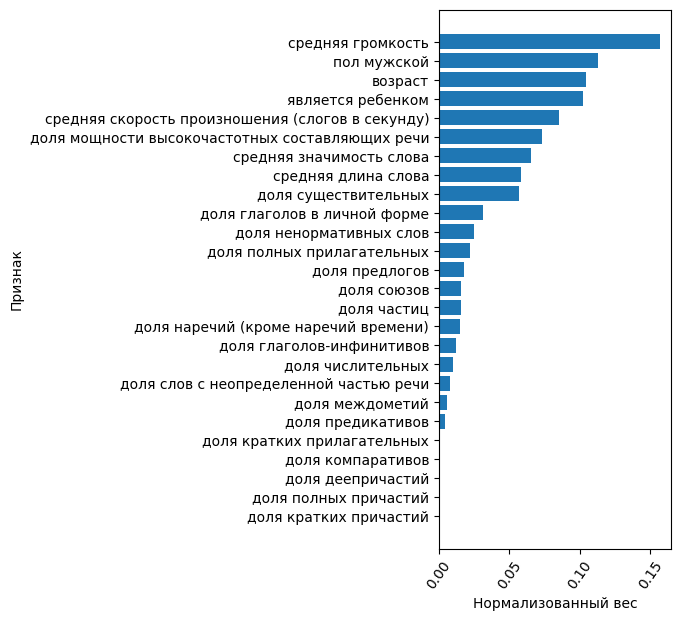

In [80]:
normalized_feature_importance_plot(
    feature_names=list(map(HLF_ENG_2_RU_RENAMER, X_test.columns)),
    feature_weights=cb.feature_importances_, 
    xticks_rotation=55,
    figsize = (3, 7),
)

# Insights

## Permutation importance

Перестановочная важность


/tmp/ipykernel_1924392/2230965713.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


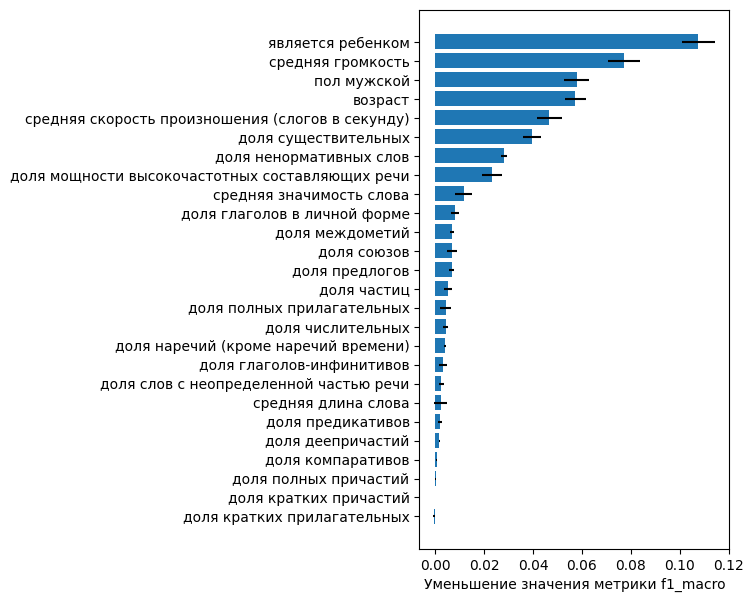

In [81]:
metric_name:str = 'f1_macro'  # accuracy, neg_log_loss
# Compute permutation importance
permutation_importance_result:Bunch = permutation_importance(
    estimator=cb, 
    X=X_test, 
    y=y_test,
    n_repeats=10,
    random_state=RANDOM_SEED,
    scoring=metric_name,
)

# Organize results
importance_df = pd.DataFrame({
    'features': list(map(HLF_ENG_2_RU_RENAMER, X_test.columns)),
    'importance_mean': permutation_importance_result.importances_mean,
    'importance_std': permutation_importance_result.importances_std
}).sort_values('importance_mean', ascending=False)

plt.figure(figsize=(4, 7))
plt.barh(
    importance_df['features'],
    importance_df['importance_mean'], 
    xerr=importance_df['importance_std'],
    align=ALIGN_CENTER_KEYWORD,
)
plt.gca().invert_yaxis()  # Most important at top
print('Перестановочная важность')
# plt.legend() # TODO: add xerr, and just bur explanation
plt.xlabel(f'Уменьшение значения метрики {metric_name}')
plt.tight_layout()
plt.show()

## Partial dependence

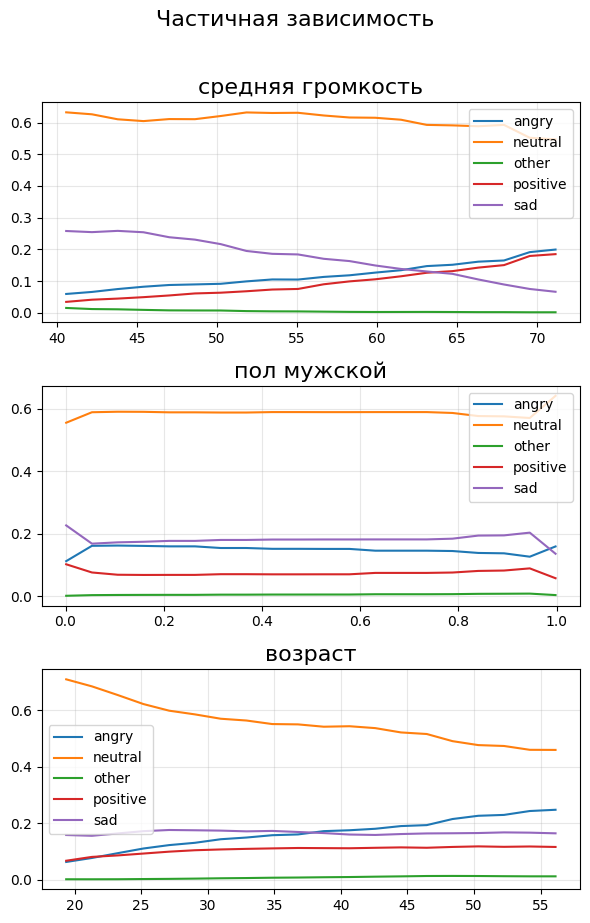

In [83]:
plot_partial_dependence_catboost(
    model=cb,
    X=X_test,
    top_features=3,
)

## SHAP

/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()
/home/vvkiselev/projects/dpl/MyProject/visualization/insights/SHAP.py:50: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Важность признаков, основанная на значениях Шепли


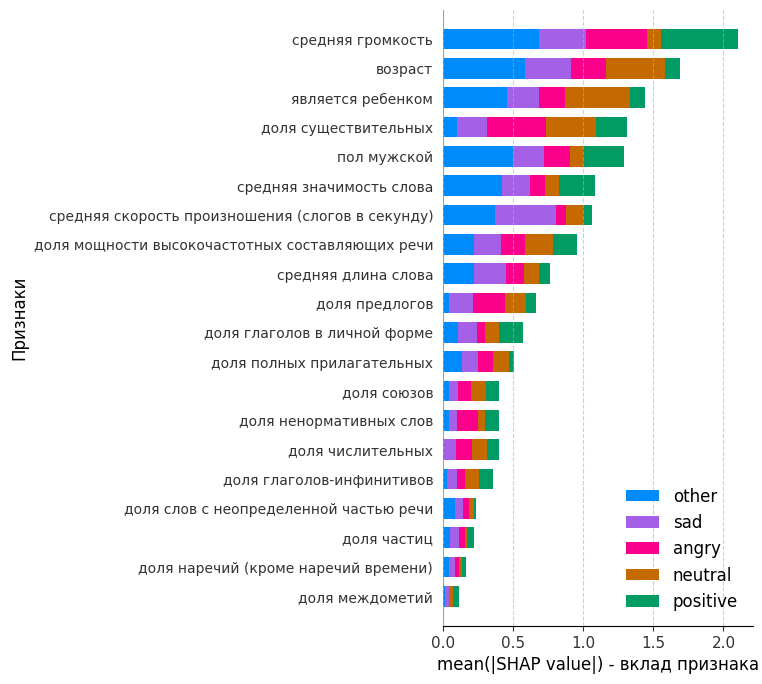

In [ ]:
shap_tree_feature_importance(
    model=cb,
    X_test=X_test,
    y_test=y_test,
    column_names=list(map(HLF_ENG_2_RU_RENAMER, X_test.columns)),
    class_names=cb.classes_,
    figsize=(4,8)
)

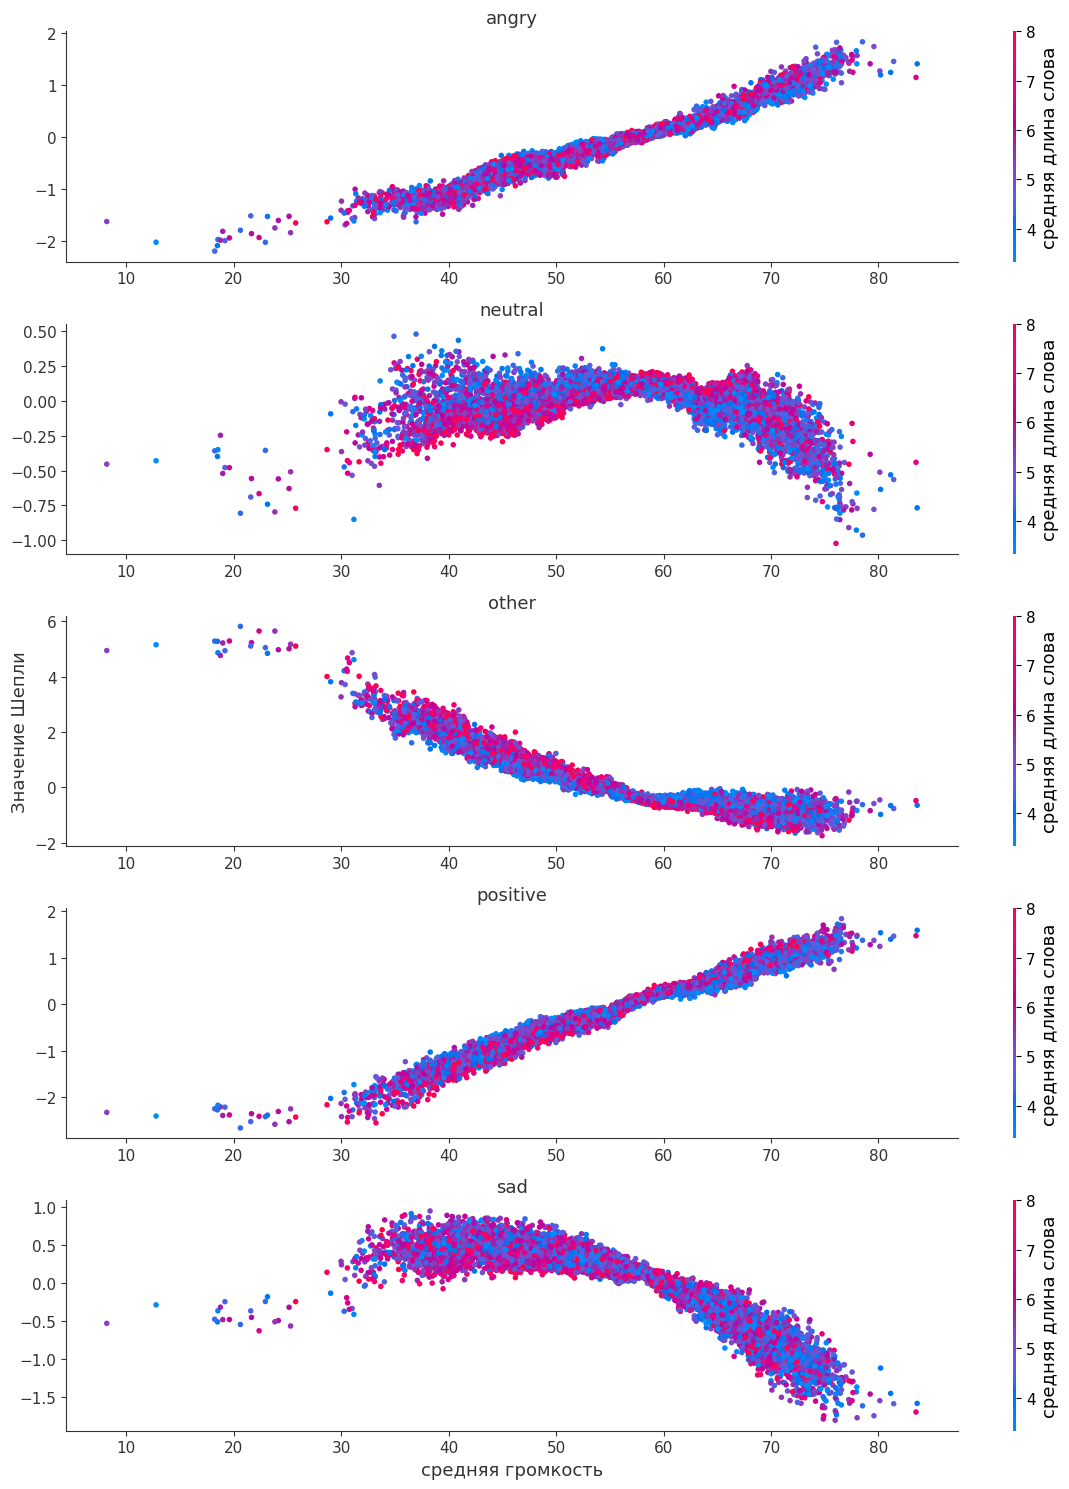

In [92]:
feature_shap_dependence_plot(
    tree_model=cb,
    X=X_test,
    cols_names=list(map(HLF_ENG_2_RU_RENAMER, X_test.columns)),
    y=y_test,
    feature_name='loudness',
    feature_interaction_name='transcription_features_mean_words_length',
)

Значения Шепли для конкретной записи. Предсказанный класс - angry, истинный класс - angry


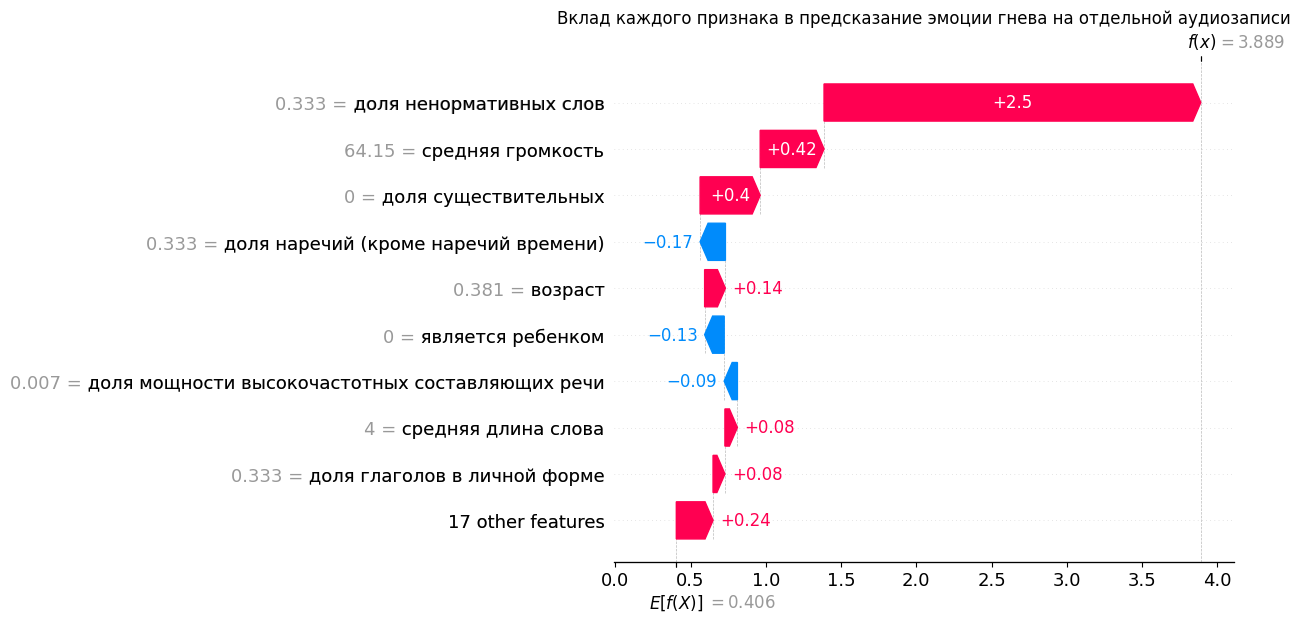

In [ ]:
shap_row_waterfall_plot(
    tree_model=cb,
    row_index='4bd5a9c05848ff92c9a002d92604714f',
    X=X_test,
    y=y_test,
    cols_names=list(map(HLF_ENG_2_RU_RENAMER, X_test.columns)),
    title='Вклад каждого признака в предсказание эмоции гнева на отдельной аудиозаписи',
    # figsize=(1, 6),
)

Значения Шепли для конкретной записи. Предсказанный класс - neutral, истинный класс - neutral


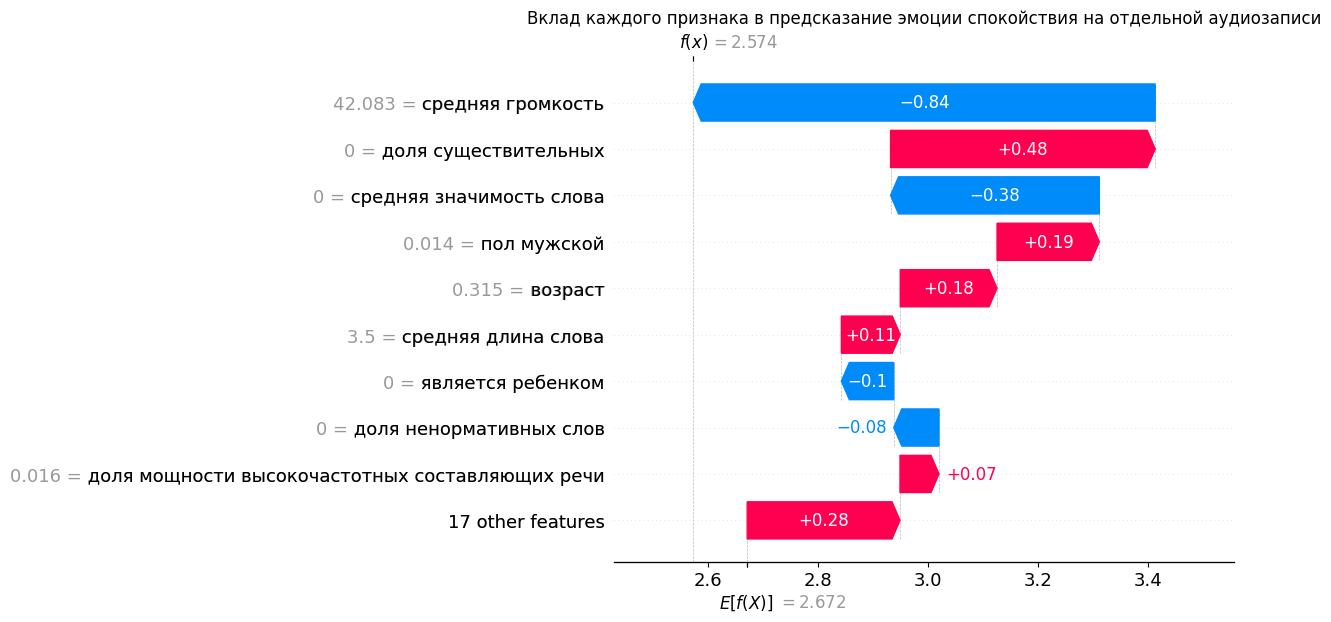

In [52]:
shap_row_waterfall_plot(
    tree_model=cb,
    row_index='9e9961c53ca6eeb440b217e539fbf46c',
    X=X_test,
    y=y_test,
    cols_names=list(map(HLF_ENG_2_RU_RENAMER, X_test.columns)),
    title='Вклад каждого признака в предсказание эмоции спокойствия на отдельной аудиозаписи',
)


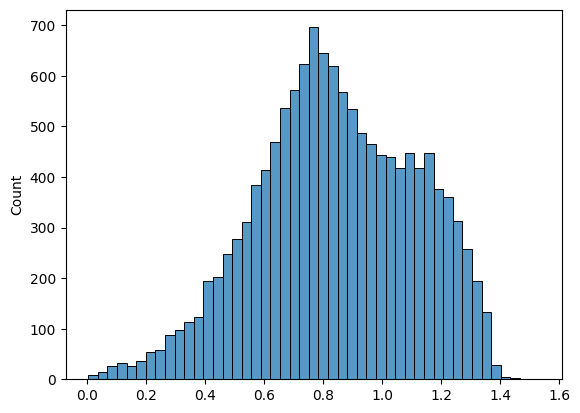

In [157]:
probs:pd.DataFrame = pd.DataFrame(cb.predict_proba(X_test), index=X_test.index, columns=cb.classes_)
probs_entropy:np.ndarray = entropy(probs, axis=1) # -np.sum(probs * np.log2(probs + EPSILON), axis=1) 
sns.histplot(probs_entropy)
plt.show()

In [158]:
cb_y_preds_proba:List[pd.DataFrame] = []
for random_seed in tqdm(range(10)):
    cb_el:CatBoostClassifier = CatBoostClassifier(
        # iterations=100,       # Number of boosting iterations
        # learning_rate=0.1,    # Learning rate
        # depth=6,              # Depth of the trees
        verbose=0,           # Print progress every 100 iterations
        random_state=random_seed,
    )
    cb_el.fit(
        X_train, 
        y_train,
        sample_weight=y_train.map(wheight_func),
    )

    cb_el_y_pred:pd.Series = pd.Series(cb_el.predict(X_test).squeeze(1), index=X_test.index, name=PREDICTIONS_COL_NAME)
    cb_el_y_pred_proba:pd.DataFrame = pd.DataFrame(cb_el.predict_proba(X_test), index=X_test.index, columns=cb_el.classes_)
    cb_y_preds_proba.append(cb_el_y_pred_proba)


cb_y_preds_proba_tables:np.ndarray = np.stack(cb_y_preds_proba)  # (n_models, n_samples, n_classes)
mean_ensemble_proba:pd.DataFrame = cb_y_preds_proba_tables.mean(axis=0)              # (n_samples, n_classes)
ensemble_mean_entropy:pd.Series = pd.Series(entropy(mean_ensemble_proba, axis=1), index=X_test.index)

100%|██████████| 10/10 [02:34<00:00, 15.50s/it]


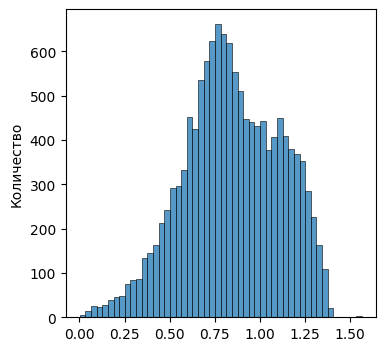

Распределение энтропии предсказаний, усредненных по моделям в ансамбле


In [ ]:
plt.figure(figsize=UNCERTAINTY_ESTIMATION_PLOTS_FIGSIZE)  
sns.histplot(ensemble_mean_entropy, bins=50)
plt.ylabel('Количество')
plt.show()
print('Распределение энтропии предсказаний, усредненных по моделям в ансамбле')


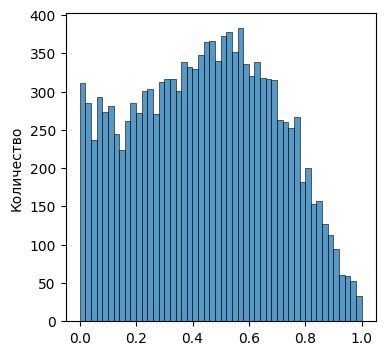

Разница между наибольшей и второй по величине вероятностями


In [ ]:
# Convert to numpy array for efficiency
cb_y_pred_proba_values:np.ndarray = cb_y_pred_proba.values
# Sort probabilities in descending order for each row
sorted_probas:np.ndarray = np.sort(cb_y_pred_proba_values, axis=1)[:, ::-1]

# Compute margin: difference between highest and second-highest
margin:pd.Series = pd.Series(sorted_probas[:, 0] - sorted_probas[:, 1], index=cb_y_pred_proba.index, name='margin')

plt.figure(figsize=UNCERTAINTY_ESTIMATION_PLOTS_FIGSIZE)  
sns.histplot(margin, bins=50)
plt.ylabel('Количество')
plt.xlabel(None)
plt.show()
print('Разница между наибольшей и второй по величине вероятностями')

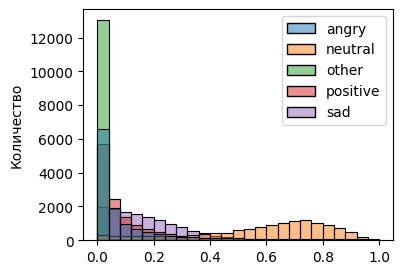

Распределения вероятностей предсказаний классов


In [ ]:
plt.figure(figsize=(4,3))  
# plt.legend(fontsize=26)
sns.histplot(probs, bins=25)

plt.ylabel('Количество') # fontsize=16
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
plt.show()
print('Распределения вероятностей предсказаний классов')

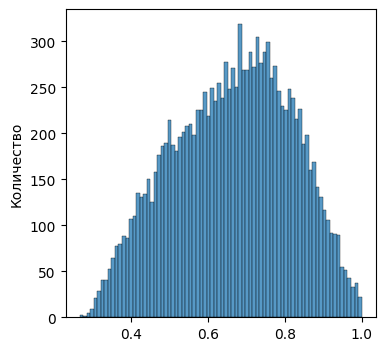

Распределение максимальной предсказанной вероятности среди классов


In [162]:
plt.figure(figsize=UNCERTAINTY_ESTIMATION_PLOTS_FIGSIZE)
sns.histplot(probs.max(axis=1), bins=80)
plt.ylabel('Количество')

plt.show()
print('Распределение максимальной предсказанной вероятности среди классов')

In [163]:
def entropy(probs):
    eps = 1e-12
    probs = np.clip(probs, eps, 1.0)
    return -np.sum(probs * np.log(probs))

plt.figure(figsize=(4,3))  

entropies:pd.Series = probs.apply(entropy, axis=1)

<Figure size 400x300 with 0 Axes>

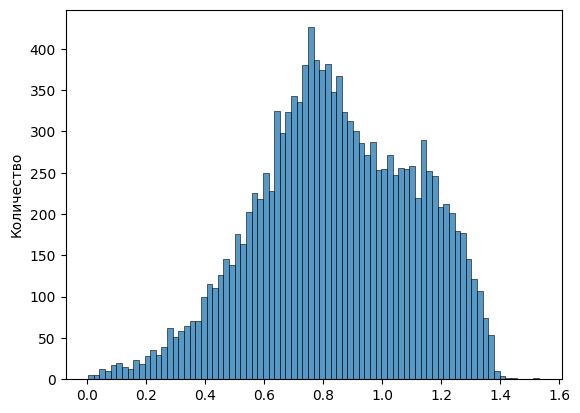

Распределение энтропии предсказаний


In [ ]:

sns.histplot(entropies, bins=80)
plt.ylabel('Количество')
plt.show()
print('Распределение энтропии предсказаний')

## Decision tree

In [135]:
dtree:DecisionTreeClassifier = DecisionTreeClassifier(max_depth=10)
dtree.fit(X_train, y_train)
print(dtree.classes_)

dtree_y_pred:pd.Series = pd.Series(data= dtree.predict(X_test), index=y_test.index, name=PREDICTIONS_COL_NAME)

['angry' 'neutral' 'other' 'positive' 'sad']


In [136]:
dump_2_file(
    object=dtree,
    path=MY_LAST_DTREE_MODEL_PATH,
)
dtree = read_dumped(
    path=MY_LAST_DTREE_MODEL_PATH
)

              precision    recall  f1-score   support

       angry       0.56      0.28      0.38      1435
     neutral       0.68      0.96      0.80      8565
       other       0.75      0.40      0.53       136
    positive       0.38      0.07      0.12      1150
         sad       0.25      0.01      0.03      1883

    accuracy                           0.67     13169
   macro avg       0.53      0.35      0.37     13169
weighted avg       0.58      0.67      0.58     13169



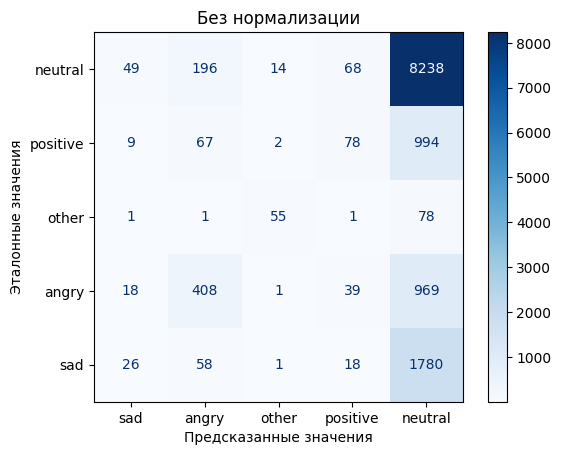

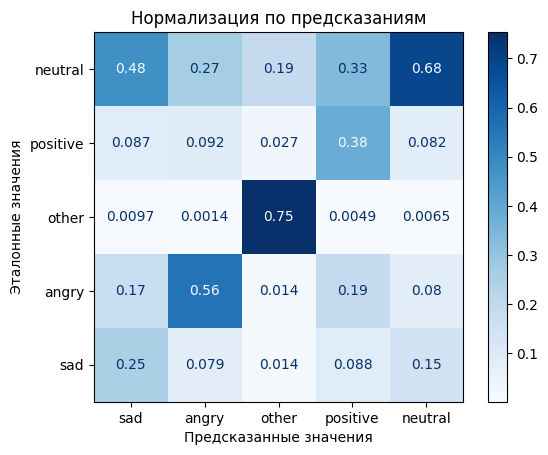

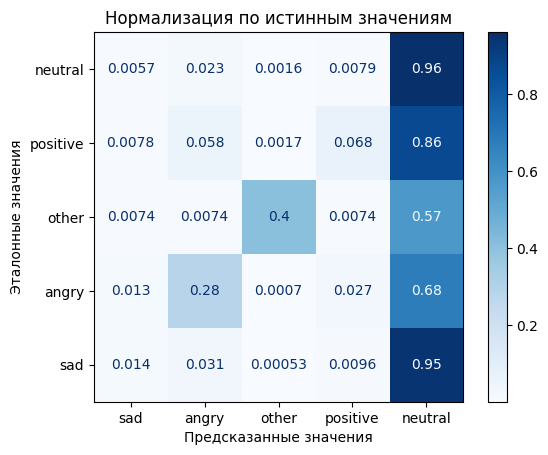

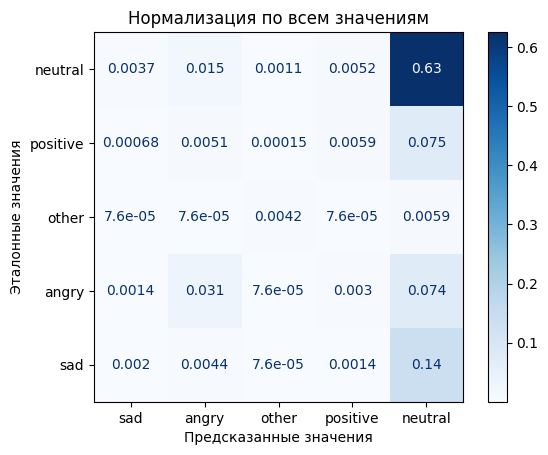

In [137]:
show_all_classification_metrics(y_true=y_test, y_pred=dtree_y_pred) 

In [138]:
classification_report_formatted(y_true=y_test, y_pred=dtree_y_pred)

,angry,neutral,other,positive,sad,macro avg,weighted avg
precision,0.56,0.68,0.75,0.38,0.25,0.53,0.58
recall,0.28,0.96,0.40,0.07,0.01,0.35,0.67
f1-score,0.38,0.80,0.53,0.12,0.03,0.37,0.58
support,1435.00,8565.00,136.00,1150.00,1883.00,13169.00,13169.00


## Linear

In [69]:
scaler = StandardScaler()
X_train_normed = pd.DataFrame(data=scaler.fit_transform(X_train),columns=X_train.columns)
X_test_normed = pd.DataFrame(data=scaler.transform(X_test),columns=X_test.columns)

label_encoder:LabelEncoder = LabelEncoder()
y_encoded:pd.Series = pd.Series(
    label_encoder.fit_transform(y_train), 
    index=y_train.index,
)

In [70]:
linear_none = LogisticRegression(
    penalty=None, 
    multi_class=SKLEARN_MULTINOMIAL_KEYWORD,
    max_iter=1000,
)
linear_none.fit(X_train_normed, y_encoded)
linear_none_y_pred:pd.Series = pd.Series(data=label_encoder.inverse_transform(linear_none.predict(X_test)), index=X_test.index, name=PREDICTIONS_COL_NAME)
show_all_classification_metrics(y_true=y_test, y_pred=linear_none_y_pred, plot_cm=False)

/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

       angry       0.00      0.00      0.00      1435
     neutral       0.00      0.00      0.00      8565
       other       0.00      0.00      0.00       136
    positive       0.09      1.00      0.16      1150
         sad       0.00      0.00      0.00      1883

    accuracy                           0.09     13169
   macro avg       0.02      0.20      0.03     13169
weighted avg       0.01      0.09      0.01     13169



/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [71]:
# 2. L1 regularization (Lasso)
linear_l1 = LogisticRegression(
    penalty='l1', 
    solver='saga', 
    multi_class=SKLEARN_MULTINOMIAL_KEYWORD,
    max_iter=1000,
)
linear_l1.fit(X_train_normed, y_encoded)
linear_l1_pred:pd.Series = pd.Series(linear_l1.predict(X_test_normed), name=PREDICTIONS_COL_NAME)
linear_l1_pred:pd.Series = pd.Series(data=label_encoder.inverse_transform(linear_l1.predict(X_test)), index=X_test.index, name=PREDICTIONS_COL_NAME)
show_all_classification_metrics(y_true=y_test, y_pred=linear_l1_pred, plot_cm=False)

/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


KeyboardInterrupt: 

In [133]:
# 3. L2 regularization (Ridge)
linear_l2 = LogisticRegression(
    penalty='l2', 
    multi_class=SKLEARN_MULTINOMIAL_KEYWORD,
    max_iter=1000,
)
linear_l2.fit(X_train_normed, y_encoded)
linear_l2_pred:pd.Series = pd.Series(linear_l2.predict(X_test_normed), name=PREDICTIONS_COL_NAME)
linear_l2_pred:pd.Series = pd.Series(data=label_encoder.inverse_transform(linear_l2.predict(X_test)), index=X_test.index, name=PREDICTIONS_COL_NAME)
show_all_classification_metrics(y_true=y_test, y_pred=linear_l2_pred, plot_cm=False)

/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

       angry       0.11      1.00      0.20      1436
     neutral       0.00      0.00      0.00      8578
       other       0.00      0.00      0.00       154
    positive       0.00      0.00      0.00      1150
         sad       0.00      0.00      0.00      1890

    accuracy                           0.11     13208
   macro avg       0.02      0.20      0.04     13208
weighted avg       0.01      0.11      0.02     13208



/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

## Text embeddings

In [ ]:
# from transformers import AutoTokenizer, AutoModel
# import torch

# # Initialize model and tokenizer
# ROSBERTA_EMBEDDER_MODEL_NAME:str = 'ai-forever/ru-en-RoSBERTa'
# tokenizer = AutoTokenizer.from_pretrained(ROSBERTA_EMBEDDER_MODEL_NAME)
# model = AutoModel.from_pretrained(ROSBERTA_EMBEDDER_MODEL_NAME)

# def mean_pooling(model_output, attention_mask):
#     token_embeddings = model_output.last_hidden_state
#     input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
#     return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# # Russian text processing
# texts = ["Ваш текст на русском языке здесь"]
# encoded_input = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')

# with torch.no_grad():
#     model_output = model(**encoded_input)

# # Choose pooling method
# embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
# # embeddings = model_output.last_hidden_state[:,0]  # CLS pooling alternative


In [ ]:
def mean_pooling(
    model_output:transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions, 
    attention_mask:torch.Tensor,
    )->torch.Tensor:
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=CLAMP_MIN)


In [242]:
model_path:Path = Path('/data01/vvkiselev/data/other/dpl/models/ru-en-RoSBERTa')
tokenizer:transformers.models.roberta.tokenization_roberta_fast.RobertaTokenizerFast = AutoTokenizer.from_pretrained(model_path)
model:transformers.models.roberta.modeling_roberta.RobertaModel = AutoModel.from_pretrained(model_path).to(ROSBERTA_DEVICE)

Some weights of RobertaModel were not initialized from the model checkpoint at /data01/vvkiselev/data/other/dpl/models/ru-en-RoSBERTa and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [244]:
def texts_2_embeddings(
    texts:List[str],
    tokenizer:transformers.models.roberta.tokenization_roberta_fast.RobertaTokenizerFast,
    model:transformers.models.roberta.modeling_roberta.RobertaModel,
    padding:bool=True,
    truncation:bool=False,
    return_tensors=TORCH_TENSORS_KEYWOED,
    device=ROSBERTA_DEVICE,
    attention_mask_keyword:str=ATTENTION_MASK_KEYWORD,
    normalize_p:int = ROSBERTA_NORMALIZE_P,
    normalize_dim:int = ROSBERTA_NORMALIZE_DIM,
    )->torch.Tensor:
    inputs:transformers.tokenization_utils_base.BatchEncoding = tokenizer(
        texts,
        padding=padding,
        truncation=truncation,
        return_tensors=return_tensors,
    ).to(device)  # Move inputs to GPU

    # Generate embeddings
    with torch.no_grad():
        outputs:transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions = model(**inputs)

    # Apply manual pooling
    sentence_embeddings:torch.Tensor = mean_pooling(
        model_output=outputs, 
        attention_mask=inputs[attention_mask_keyword],
    )
    embeddings:torch.Tensor = torch.nn.functional.normalize(
        sentence_embeddings, 
        p=normalize_p, 
        dim=normalize_dim,
    )

    # print(f"Embedding shape: {embeddings.shape}")  # Output: torch.Size([1, 1024])
    return embeddings


In [269]:
embs:torch.Tensor = texts_2_embeddings(
    # texts=['Пример русского текста для анализа','я пошел гулять'],
    texts=list(filter(lambda x: isinstance(x, str), list(raw_crowd_train[SPEAKER_TEXT_FIELD_NAME].head(5000).unique()))),
    tokenizer=tokenizer,
    model=model,
)
embs.shape

torch.Size([2112, 1024])

In [256]:
raw_crowd_train.head()[SPEAKER_TEXT_FIELD_NAME].to_list()

['не надо не надо не надо не надо',
 'фозил кори mp три',
 nan,
 'сколько стоит на керамбит',
 'афина когда закончится эта телепередача']

In [296]:
def transcriptions_series_to_text_2_emb(
    transcriptions_series:pd.Series,
    tokenizer:transformers.models.roberta.tokenization_roberta_fast.RobertaTokenizerFast,
    model:transformers.models.roberta.modeling_roberta.RobertaModel,
    num_chunks:int,
    padding:bool=True,
    truncation:bool=False,
    return_tensors=TORCH_TENSORS_KEYWOED,
    device=ROSBERTA_DEVICE,
    attention_mask_keyword:str=ATTENTION_MASK_KEYWORD,
    normalize_p:int = ROSBERTA_NORMALIZE_P,
    normalize_dim:int = ROSBERTA_NORMALIZE_DIM,
    )->Dict[str, torch.Tensor]:
    unique_texts:List[str] = list(
        filter(
            lambda x: isinstance(x, str), 
            list(transcriptions_series.unique())
        )
    )
    print(f'len(unique_texts) = {len(unique_texts)}')

    chunks:List[List[str]] = divide_into_chunks(unique_texts, num_chunks)
    unique_text_2_embedding:Dict[str, torch.Tensor] = {}
    for chunk in tqdm(chunks):
        chunk_embeddings:torch.Tensor = texts_2_embeddings(
            texts=chunk,
            tokenizer=tokenizer,
            model=model,
            padding=padding,
            truncation=truncation,
            return_tensors=return_tensors,
            device=device,
            attention_mask_keyword=attention_mask_keyword,
            normalize_p=normalize_p,
            normalize_dim=normalize_dim,
        ).cpu()
        # print(f'chunk_embeddings.shape = {chunk_embeddings.shape}')
        for chunk_i in range(len(chunk)):
            unique_text_2_embedding[chunk[chunk_i]] = chunk_embeddings[chunk_i]

    return unique_text_2_embedding
        

In [304]:
text_2_emb_train:Dict[str, torch.Tensor] = transcriptions_series_to_text_2_emb(
    transcriptions_series=raw_crowd_train[SPEAKER_TEXT_FIELD_NAME],
    tokenizer=tokenizer,
    model=model,
    num_chunks=100,
)

len(unique_texts) = 124568


100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


In [310]:
text_2_emb_series_train:pd.Series = pd.Series(index=text_2_emb_train.keys(), data=map(repr, text_2_emb_train.values()))
text_2_emb_series_train.head()

не надо не надо не надо не надо                   tensor([ 0.0409,  0.0645, -0.0062,  ...,  0.01...
фозил кори mp три                                 tensor([-0.0066,  0.0331,  0.0023,  ...,  0.01...
сколько стоит на керамбит                         tensor([ 0.0246,  0.0035,  0.0029,  ..., -0.02...
афина когда закончится эта телепередача           tensor([ 0.0242,  0.0469,  0.0188,  ...,  0.01...
где проживают дети путина тихонова и воронцова    tensor([-0.0016, -0.0451, -0.0002,  ...,  0.05...
dtype: object

In [333]:
torch.save(text_2_emb_train, PROCESSED_DUSHA_CROWD_TRAIN_TEXT_EMBEDDINGS_LAST_VERSION_FILE_PATH)

In [332]:
# Load the dictionary from the file
# loaded_dict = torch.load(PROCESSED_DUSHA_CROWD_TRAIN_TEXT_EMBEDDINGS_LAST_VERSION_FILE_PATH, weights_only=False)
# list(loaded_dict.items())[0][1].shape

FileNotFoundError: [Errno 2] No such file or directory: '/data01/vvkiselev/data/other/dpl/processed/dusha/crowd/train/text_embeddings/v1.pt'

In [297]:
text_2_emb_test:Dict[str, torch.Tensor] = transcriptions_series_to_text_2_emb(
    transcriptions_series=raw_crowd_test[SPEAKER_TEXT_FIELD_NAME],
    tokenizer=tokenizer,
    model=model,
    num_chunks=100,
)

len(unique_texts) = 16628


100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


In [334]:
torch.save(text_2_emb_test, PROCESSED_DUSHA_CROWD_TEST_TEXT_EMBEDDINGS_LAST_VERSION_FILE_PATH)

In [335]:
loaded_dict = torch.load(PROCESSED_DUSHA_CROWD_TEST_TEXT_EMBEDDINGS_LAST_VERSION_FILE_PATH, weights_only=False)
list(loaded_dict.items())[0][1].shape

torch.Size([1024])

# Whisper-large

# Bio model

In [2]:
bio_model:Wav2VecBioModel = Wav2VecBioModel.dir_path_with_device_init(
    device=BIO_MODEL_DEVICE,
)

bio_model_pred_proba:Wav2VecBioModelPredProba = bio_model.audio_file_path_2_predict(
    path=Path('/data01/vvkiselev/data/other/dpl/processed/dusha/crowd/train/wavs/0002600403a116020fa591faf05a31de.wav'), # male
    # path=Path('/data01/vvkiselev/data/other/dpl/processed/dusha/crowd/train/wavs/00000d522439136554c888f4cfd92131.wav'), # young female
)
print(bio_model_pred_proba)
bio_model_pred_proba.to_speaker_bio()